In [6]:
library(IRdisplay)
library(Cairo)

library(data.table)
library(arrow)
library(ggplot2)
library(cowplot)
library(ggrepel)
library(ggthemes)
library(ggpubr)
library(ggtext)
library(patchwork)
library(grid)
library(gridExtra)
library(scales)
library(stringr)
library(RColorBrewer)
library(yaml)
library(plyr)
library(tidyverse)
library(png)
library(rstatix)


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp



Attaching package: ‘ggthemes’


The following object is masked from ‘package:cowplot’:

    theme_map



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots



Attaching package: ‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()      masks plyr::arrange()
✖ dplyr::between()      masks data.table::between()
✖ readr::col_factor()   masks scales::col_factor()
✖ dplyr::combine()      masks gr

In [7]:
# set global plot parameters
FONTSIZE = 12
THEME = theme_cowplot(font_size = FONTSIZE, font_family = 'Helvetica') + theme(plot.tag = element_text(face = "bold"))

In [31]:
output_path = '/data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots'

In [20]:
tss_auprc_path = 'tss_auprc_bins.parquet'
cse_auprc_path = 'cse_auprc_bins.parquet'

In [52]:
# Add the new y-position column based on outlier_state
tss_auprc_df = open_dataset(tss_auprc_path) %>% collect() %>% as.data.table()
tss_auprc_df[, auprc_diff := auprc_new - auprc_old]
tss_auprc_df[, start_value := as.numeric(sub("\\[(.*),.*", "\\1", bin_name))]
tss_auprc_df[, bin_name := reorder(`bin_name`, `start_value`)]

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”


In [51]:
# Add the new y-position column based on outlier_state
cse_auprc_df = open_dataset(cse_auprc_path) %>% collect() %>% as.data.table()
cse_auprc_df[, auprc_diff := auprc_new - auprc_old]
cse_auprc_df[, start_value := as.numeric(sub("\\[(.*),.*", "\\1", bin_name))]
cse_auprc_df[, bin_name := reorder(`bin_name`, `start_value`)]

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”


In [23]:
head(tss_auprc_df)

tissue,auprc_new,bin_name,auprc_old,auprc_diff,start_value
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Colon,0.05395103,"[-700, -650)",0.05393214,1.888642e-05,-700
Uterus,0.02856501,"[-800, -750)",0.02856379,1.218369e-06,-800
Skin,0.09693029,"[-600, -550)",0.09688526,4.502996e-05,-600
Brain,0.07222804,"[-950, -900)",0.07323903,-1.010990e-03,-950
Pituitary,0.02426282,"[-1100, -1050)",0.02426330,-4.737569e-07,-1100
Adipose Tissue,0.07005317,"[1000, 1050)",0.07007975,-2.658531e-05,1000


In [24]:
head(cse_auprc_df)

tissue,auprc_new,bin_name,auprc_old,auprc_diff,start_value
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Vagina,0.001998612,"[1450, 1500)",0.001999388,-7.755595e-07,1450
Kidney,0.125002600,"[-2000, -1950)",0.125002600,4.732514e-11,-2000
Kidney,0.125002600,"[200, 250)",0.125002600,0.000000e+00,200
Liver,0.011935713,"[400, 450)",0.011935736,-2.356809e-08,400
Esophagus,0.077923058,"[-1100, -1050)",0.077925204,-2.145644e-06,-1100
Liver,0.011935818,"[800, 850)",0.011935736,8.213865e-08,800


In [13]:
log10_math_format <- function(x) {
  exponent <- floor(log10(x))
  base <- round(x / 10^exponent, 0)
  if (exponent < 4) {
      return(x)
  } else if (base == 1) {
    return(bquote(10^.(exponent)))  # 10^x format when base is 1
  }  else {
    return(bquote(.(base) %*% 10^.(exponent)))  # Base * 10^x format
  }
}

In [58]:
bins[seq(1, length(bins), by = 5)]

[1] "[-2000, -1950)" "[-1750, -1700)" "[-1500, -1450)" "[-1250, -1200)"
 [5] "[-1000, -950)"  "[-750, -700)"   "[-500, -450)"   "[-250, -200)"  
 [9] "[0, 50)"        "[250, 300)"     "[500, 550)"     "[750, 800)"    
[13] "[1000, 1050)"   "[1250, 1300)"   "[1500, 1550)"   "[1750, 1800)"  
[17] "no_label"

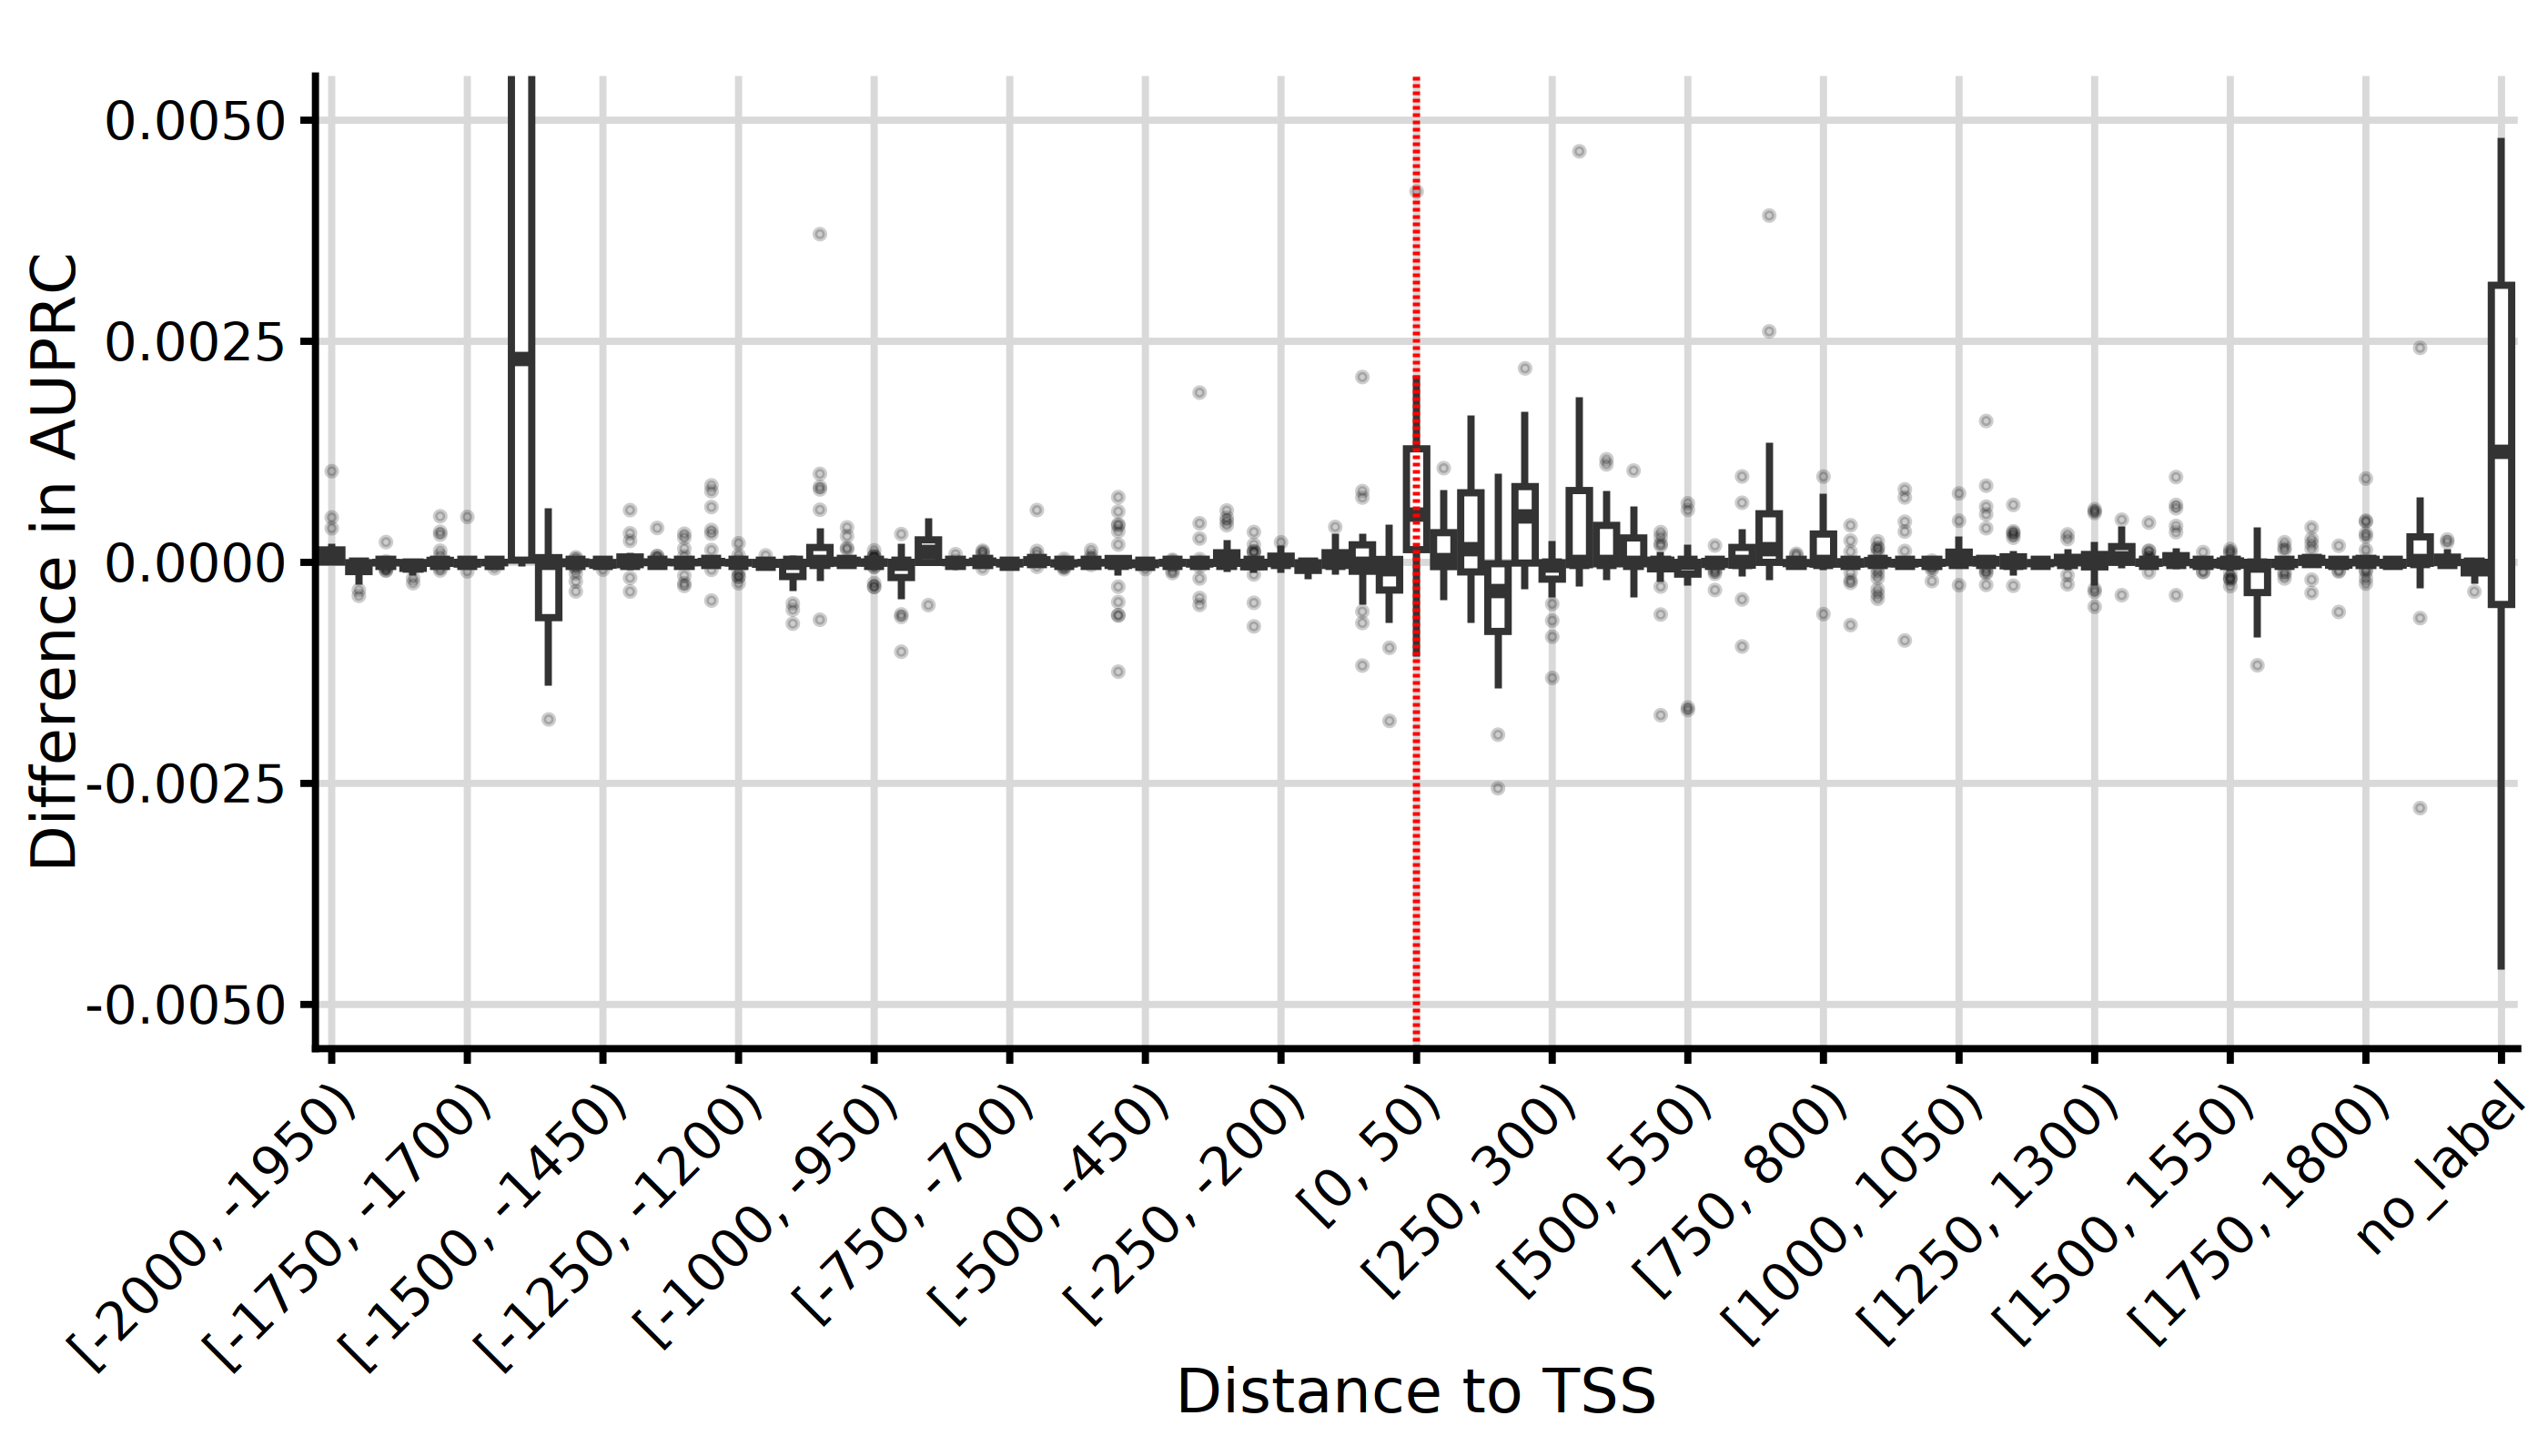

In [79]:
options(repr.plot.width=7, repr.plot.height=4, repr.plot.res=400)
bins = levels(tss_auprc_df$bin_name)
p1 = (
    ggplot(tss_auprc_df, aes(x=`bin_name`))
    + geom_boxplot(aes(y=`auprc_diff`), outlier.size=0.5, outlier.color='#00000032')
    + THEME
    + theme(
        axis.text.x=element_text(angle = 45, hjust = 1),
        legend.position = c(0.7, 0.9),
        legend.margin=margin(-15,15,2,2),
        legend.background=element_rect(fill='white', color='black', linewidth=0.3)
    )
    + labs(
        x="Distance to TSS", 
        y="Difference in AUPRC",
        color="",
        fill="",
        title=element_blank(),
    )
    + coord_cartesian(ylim=c(-0.005, 0.005))
    + guides(size='none', fill = guide_legend(reverse = TRUE))
    + background_grid()
    + scale_x_discrete(breaks = bins[seq(1, length(bins), by = 5)])
    + geom_vline(xintercept = 41, color = "red", linetype = "dashed")
    )
p1

In [80]:
width=7
height=4

path = paste(output_path, 'auprc_diff_tss', sep='/')
print(paste0("Saving to ", path, "..."))
ggsave(paste0(path, ".png"), p1, width = width, height = height, dpi=600, type='cairo')

[1] "Saving to /data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/auprc_diff_tss..."


Warning message:
“Using ragg device as default. Ignoring `type` and `antialias` arguments”


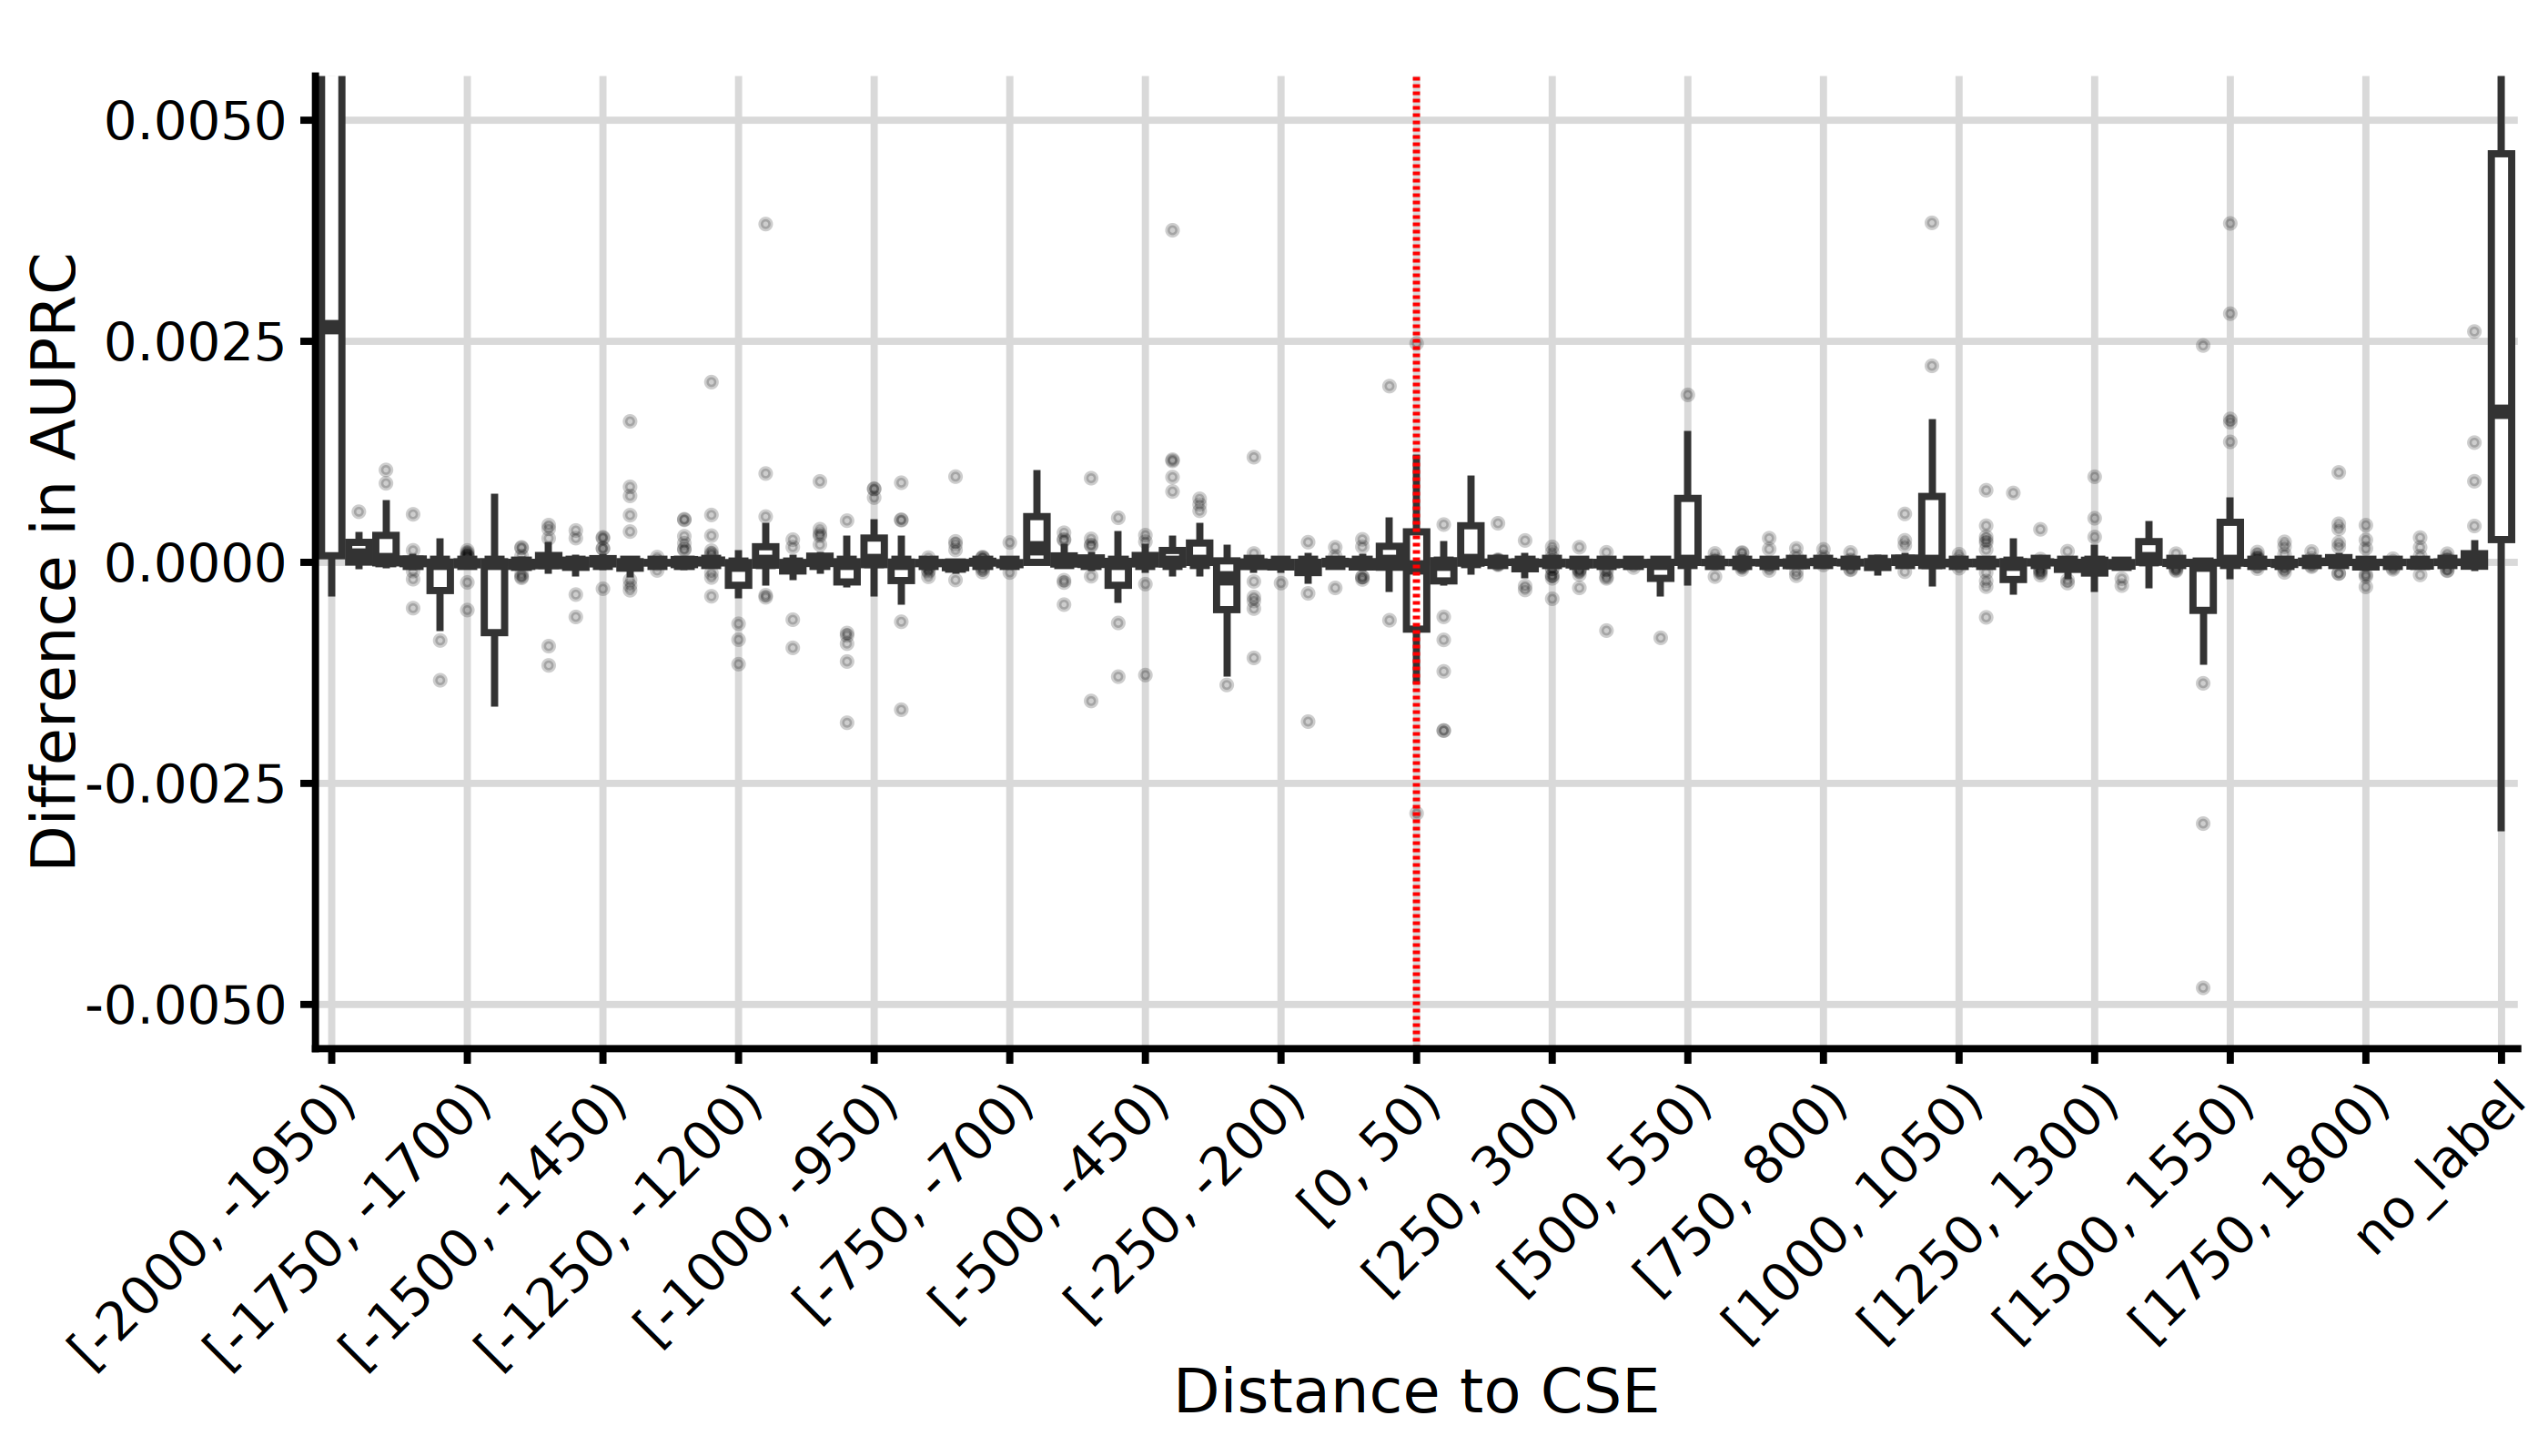

In [81]:
options(repr.plot.width=7, repr.plot.height=4, repr.plot.res=400)
bins = levels(cse_auprc_df$bin_name)
p2 = (
    ggplot(cse_auprc_df, aes(x=reorder(`bin_name`, `start_value`)))
    + geom_boxplot(aes(y=`auprc_diff`), outlier.size=0.5, outlier.color='#00000032')
    + THEME
    + theme(
        axis.text.x=element_text(angle = 45, hjust = 1),
        legend.position = c(0.7, 0.9),
        legend.margin=margin(-15,15,2,2),
        legend.background=element_rect(fill='white', color='black', linewidth=0.3)
    )
    + labs(
        x="Distance to CSE", 
        y="Difference in AUPRC",
        color="",
        fill="",
        title=element_blank(),
    )
    + coord_cartesian(ylim=c(-0.005, 0.005))
    + guides(size='none', fill = guide_legend(reverse = TRUE))
    + background_grid()
    + scale_x_discrete(breaks = bins[seq(1, length(bins), by = 5)])
    + geom_vline(xintercept = 41, color = "red", linetype = "dashed")
    )
p2

In [82]:
width=7
height=4

path = paste(output_path, 'auprc_diff_cse', sep='/')
print(paste0("Saving to ", path, "..."))
ggsave(paste0(path, ".png"), p2, width = width, height = height, dpi=600, type='cairo')

[1] "Saving to /data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/auprc_diff_cse..."


Warning message:
“Using ragg device as default. Ignoring `type` and `antialias` arguments”
